# Insurance Policy Extraction and Standardization

Currently dealing with Insurers:
1. Oscar
2. Aetna 
3. Anthem
4. CMS

Solving the problem using versioning. Lets start from a basic version that handles 4-5 surgical procedures information from all the above insurers. Seems like each insurer has their own code for the each medical procedure/treatment. Lets focus on some common surgeries, as listed below:
1. Glaucoma Surgery (Oscar code: CG034, Aetna: CPB 0484, Anthem:  SURG.00095 [Not explicitly listed as glaucoma surgery], CMS: )
2. Bariatric Surgery

## Approach
For each insurer (Oscar, Aetna, Anthem, CMS Medicare Coverage Database, and potentially your own insurer) we'll need to locate the webpages containing their medical policies. We'll use the "requests" library to fetch the webpages and "BeautifulSoup" for parsing html content. using relevant libaries for policies in different formats.

When searching for surgeries, diagnostic tests, therapy etc on a particular insurers website, I want to achieve the same functionality as a search engine to match the keywords with the content available. 

### Install relevant libraries 

In [ ]:
%pip install --user requests pdfminer.six
%pip install --user bs4
%pip install --user selenium webdriver-manager
%pip install --user spacy nltk jsonschema networkx matplotlib
!python -m spacy download en_core_web_sm

In [3]:
import requests
import io
import os
from bs4 import BeautifulSoup
from pdfminer.high_level import extract_text
import re
import urllib.parse
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import time
import urllib.parse
import logging
import json
import spacy
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from jsonschema import validate
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from spacy.matcher import PhraseMatcher

### Aetna - Extract raw text data on medical necessity criteria
The below implementation should scrape Aetna's website, find the relevant html file corresponding to the treatment, parse the policy section, retrieve the text data related to Medical Necessity

Request was being interpreted by Incapsula, which is a web application firewall (WAF) and DDoS protection service. Incapsula was able to detect that the request was coming from an automated script rather than a regular browser. 

Mimic a regular browser request to get past the firewall.

Finding the appropriate section from the html "Medical Necessity" - to scale this across multiple insurers, we can make a search algorithm that looks for keywords "Medical Necessity" "Clinical Guidelines" etc

unicode escape sequences in the json file need to be treated - using python's built in JSON decoder which automatically handles these escape sequences. 

In [89]:
class AetnaPolicyExtractor:
    def __init__(self):
        self.url = None
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Referer': 'https://www.aetna.com',
            'DNT': '1',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1',
        }
        self.html_content = None
        self.soup = None
        self.criteria = []
        self.output_dir = os.path.join(os.getcwd(), 'aetna_raw_data')

    def load_url(self, url):
        self.url = url

    def extract_html(self):
        try:
            response = requests.get(self.url, headers=self.headers)
            response.raise_for_status()
            self.html_content = response.text
            self.soup = BeautifulSoup(self.html_content, 'html.parser')
            return True
        except requests.RequestException as e:
            print(f"An error occurred while fetching the URL: {e}")
            return False

    def extract_list_items(self, element):
        items = []
        for child in element.children:
            if child.name == 'li':
                item = {'text': child.get_text(strip=True, separator=' ')}
                nested_ol = child.find('ol')
                if nested_ol:
                    item['sub_items'] = self.extract_list_items(nested_ol)
                items.append(item)
        return items

    def extract_medical_necessity_criteria(self):
        med_necessity = self.soup.find('h3', string='Medical Necessity')
        if not med_necessity:
            print("Medical Necessity section not found")
            return

        current = med_necessity.find_next()
        while current and current.name != 'h3':
            if current.name == 'ol':
                self.criteria.extend(self.extract_list_items(current))
            current = current.find_next()

    def save_to_json(self):
        if not self.criteria:
            print("No criteria to save")
            return

        # Create the output directory if it doesn't exist
        os.makedirs(self.output_dir, exist_ok=True)

        filename = f"medical_necessity_criteria_{self.url.split('/')[-1].split('.')[0]}.json"
        filepath = os.path.join(self.output_dir, filename)
        json_data = json.dumps(self.criteria, ensure_ascii=False, indent=2)
        
        try:
            with open(filepath, 'w', encoding='utf-8') as f:
                f.write(json_data)
            print(f"Medical necessity criteria have been saved to '{filepath}'")
        except IOError as e:
            print(f"An error occurred while saving to {filepath}: {e}")

    def process(self):
        if self.extract_html():
            self.extract_medical_necessity_criteria()
            self.save_to_json()
        else:
            print("Failed to extract HTML content")

In [92]:
url = "https://www.aetna.com/cpb/medical/data/500_599/0508.html"
extractor = AetnaPolicyExtractor()
extractor.load_url(url)
extractor.process()

Medical necessity criteria have been saved to 'c:\Users\divya\Python Workspace\PythonProject\aetna_raw_data\medical_necessity_criteria_0508.json'


### Fetching raw data on medical necessities for various treatments, therapies and tests

The raw data we collected for cataract surgery preserves the ordering of text related to medical necessity criteria and can now be scaled to accomodate other treatments, therapies and tests.

We'll first create a dictionary of 10 different treatments, therapies and tests along with its associated medical policy page. 

This would also help us generate a more comprehensive ontology dictionary for the next steps!

In [14]:
clinical_policy_dict = {
    "Cataract Surgery": "https://www.aetna.com/cpb/medical/data/500_599/0508.html",
    "Glaucoma Surgery": "https://www.aetna.com/cpb/medical/data/400_499/0484.html",
    "Brachial Plexus Surgery": "https://www.aetna.com/cpb/medical/data/800_899/0850.html",
    "Heart Transplantation": "https://www.aetna.com/cpb/medical/data/500_599/0586.html",
    "Influenza Rapid Diagnostic Tests": "https://www.aetna.com/cpb/medical/data/400_499/0476.html",
    "Fecal Incontinence": "https://www.aetna.com/cpb/medical/data/600_699/0611.html",
    "Salivary Tests": "https://www.aetna.com/cpb/medical/data/600_699/0608.html",
    "Lung Cancer Screening": "https://www.aetna.com/cpb/medical/data/300_399/0380.html",
    "Spinal Ultrasound": "https://www.aetna.com/cpb/medical/data/600_699/0628.html",
    "Transrectal Ultrasound": "https://www.aetna.com/cpb/medical/data/1_99/0001.html",
    "Speech Therapy": "https://www.aetna.com/cpb/medical/data/200_299/0243.html",
    "Voice Therapy": "https://www.aetna.com/cpb/medical/data/600_699/0646.html",
    "Infrared Therapy": "https://www.aetna.com/cpb/medical/data/600_699/0604.html",
    "Dysphagia Therapy": "https://www.aetna.com/cpb/medical/data/600_699/0625.html"
}

Extracting medical necessity criteria for the following clinical policies:
https://www.aetna.com/cpb/medical/data/500_599/0508.html
https://www.aetna.com/cpb/medical/data/400_499/0484.html
https://www.aetna.com/cpb/medical/data/800_899/0850.html
https://www.aetna.com/cpb/medical/data/500_599/0586.html
https://www.aetna.com/cpb/medical/data/400_499/0476.html
https://www.aetna.com/cpb/medical/data/600_699/0611.html
https://www.aetna.com/cpb/medical/data/600_699/0608.html
https://www.aetna.com/cpb/medical/data/300_399/0380.html
https://www.aetna.com/cpb/medical/data/600_699/0628.html
https://www.aetna.com/cpb/medical/data/1_99/0001.html
https://www.aetna.com/cpb/medical/data/200_299/0243.html
https://www.aetna.com/cpb/medical/data/600_699/0646.html
https://www.aetna.com/cpb/medical/data/600_699/0604.html
https://www.aetna.com/cpb/medical/data/600_699/0625.html


### Process raw data collected into a standard format

Yay! we now have all the text related to medical necessity criteria stored in raw yet structured format. Now, moving onto standardization.

To standardize the large raw medical data while maintaining its structure and logical relationship, I believe the following approach would work the best:
1. Develop a hierachical ontology for the specific treatment medical necessity criteria. This could include main categories like: functional impairment, objective findings, subjective symptoms, diagnostic tests, medical conditions, surgical procedure, IOL types etc
2. Use NLP and NER to parse the text and identify key entities relationship, and logical operators. 
3. Convert the nested JSON structure into a more formal logical representation using predicate logic or a domain-specific language.
4. Create a mapping of synonymous terms and phrases to standardized terminology. For example, map various descriptions of visual acuity to a standard scale.
5. Decision Tree or Rule-based system: constructing a decision tree or rule-based system that represents the criteria in a structured, machine readable format. Maybe use a rules engine like drools?
6. Knowledge graph: Building a knowledge graph that represents relationships between different criteria, procedures, conditions. This should allow for more flexible querying and reasoning about the criteria. 
7. Interactive visualization: Developing an interactive visualization tool that represents the standardized criteria in a user-friendly format
9. Potentially: version control and diff systems to track changes changes in criteria overtime, with a diff tool to highlight different versions. 
10. Potentially: algorithms to automatically check for inconsistencies or conflicts in criteria, both within a single insurer's policy or across multiple insurers. 
11. Semantic Annotation to help out with interoperability using Owl or Rdf
12. Natural Language Generation: generate standardized natual language description of the criteria from the structured representation ensuring consistency in how the criteria is communicated. 



### Version 1: 
1. Process the raw data collected
2. Generate a basic ontology to test out implementation
3. Use SpaCy to process each item from the raw data 
4. Logical operations are key in defining relationship between entities
5. Generate sub-items for item if they exist - will use 4. (logical operations) to define relationship between them in next version

In [8]:
# Download Natural Language Toolkit (nltk) data
# nltk.download('punkt')


class MedicalNecessityStandardizer:
    def __init__(self, json_file):
        self.raw_data = self.load_json(json_file)
        self.ontology = self.create_ontology()
        self.standardized_data = {}
        self.nlp = spacy.load("en_core_web_sm")
        self.matcher = PhraseMatcher(self.nlp.vocab, attr='LOWER')
        self.create_matcher()

    @staticmethod
    def load_json(file_path):
        with open(file_path, 'r') as file:
            return json.load(file)

    @staticmethod
    def create_ontology():
        return {
            "Visual_Acuity": ["Snellen", "LogMAR", "20/20", "20/40", "20/50", "20/60", "20/70", "20/200"],
            "Functional_Impairment": ["ADL", "driving", "reading", "television", "occupational", "avocational", "lifestyle", "independence"],
            "Objective_Findings": ["cataract", "glaucoma", "retinopathy", "opacity", "clouding"],
            "Subjective_Symptoms": ["glare", "blurred vision", "diplopia", "polyopia"],
            "Diagnostic_Tests": ["A-scan", "B-scan", "ultrasound", "optical coherence biometry", "glare testing", "contrast sensitivity testing"],
            "Medical_Conditions": ["diabetes", "hypertension", "Marfan syndrome"],
            "Surgical_Procedures": ["phacoemulsification", "ECCE", "vitrectomy", "trabeculoplasty"],
            "IOL_Types": ["monofocal", "multifocal", "toric", "accommodating"]
        }

    def create_matcher(self):
        for category, terms in self.ontology.items():
            patterns = [self.nlp.make_doc(text.lower()) for text in terms]
            self.matcher.add(category, None, *patterns)

    def standardize(self):
        for item in self.raw_data:
            standardized_item = self.standardize_item(item)
            self.validate_entities(standardized_item['standardized_entities'])
            self.standardized_data[standardized_item['id']] = standardized_item

    def standardize_item(self, item):
        standardized_item = {
            'id': self.generate_id(item),
            'text': item['text'],
            'standardized_entities': self.extract_and_standardize_entities(item['text']),
            'logical_structure': self.identify_logical_operators(item['text']),
            'sub_items': []
        }

        if 'sub_items' in item:
            standardized_item['sub_items'] = [self.standardize_item(sub_item) for sub_item in item['sub_items']]

        return standardized_item

    @staticmethod
    def generate_id(item):
        return hash(item['text']) % 10000

    def extract_and_standardize_entities(self, text):
        doc = self.nlp(text.lower())
        matches = self.matcher(doc)
        
        entities = {category: set() for category in self.ontology.keys()}
        for match_id, start, end in matches:
            category = self.nlp.vocab.strings[match_id]
            span = doc[start:end]
            entities[category].add(span.text)
        
        return {category: list(terms) for category, terms in entities.items()}

    @staticmethod
    def identify_logical_operators(text):
        tokens = word_tokenize(text.lower())
        return [('AND', i) for i, token in enumerate(tokens) if token == 'and'] + \
               [('OR', i) for i, token in enumerate(tokens) if token == 'or']

    def validate_entities(self, entities):
        for category, terms in entities.items():
            if category not in self.ontology:
                print(f"Warning: Unknown category {category}")
            for term in terms:
                if term.lower() not in [t.lower() for t in self.ontology[category]]:
                    print(f"Warning: Term '{term}' not found in category {category}")

In [9]:
treatment_id = "0508"
raw_data_file = f"medical_necessity_criteria_{treatment_id}.json"
raw_data_file_path = os.path.join(os.getcwd(), 'aetna_raw_data', raw_data_file)
standardizer = MedicalNecessityStandardizer(raw_data_file_path)
standardizer.standardize()

standardized_data_file = f"medical_necessity_criteria_standardized_{treatment_id}.json"
with open(standardized_data_file, "w", encoding="utf-8") as f:
    f.write(json.dumps(standardizer.standardized_data, indent=2))
print("Medical necessity criteria have been saved to 'medical_necessity_criteria_standardized.json'")


Medical necessity criteria have been saved to 'medical_necessity_criteria_standardized.json'


### Version 3: Creating a knowledge graph of the collected data
We have a base structured data to operate on that, albeit rudimentary, gives us the ability to manipulate the data and create meaning out of it. In our particular scenario, we'd like to envince the relationships in the medical policy data that we've so far collected and knowledge graphs could help us achieve that! 

I plan on using networkx to create a knowledge graph from the existing json file.

C:\Users\divya\AppData\Local\Temp\ipykernel_18532\468539996.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


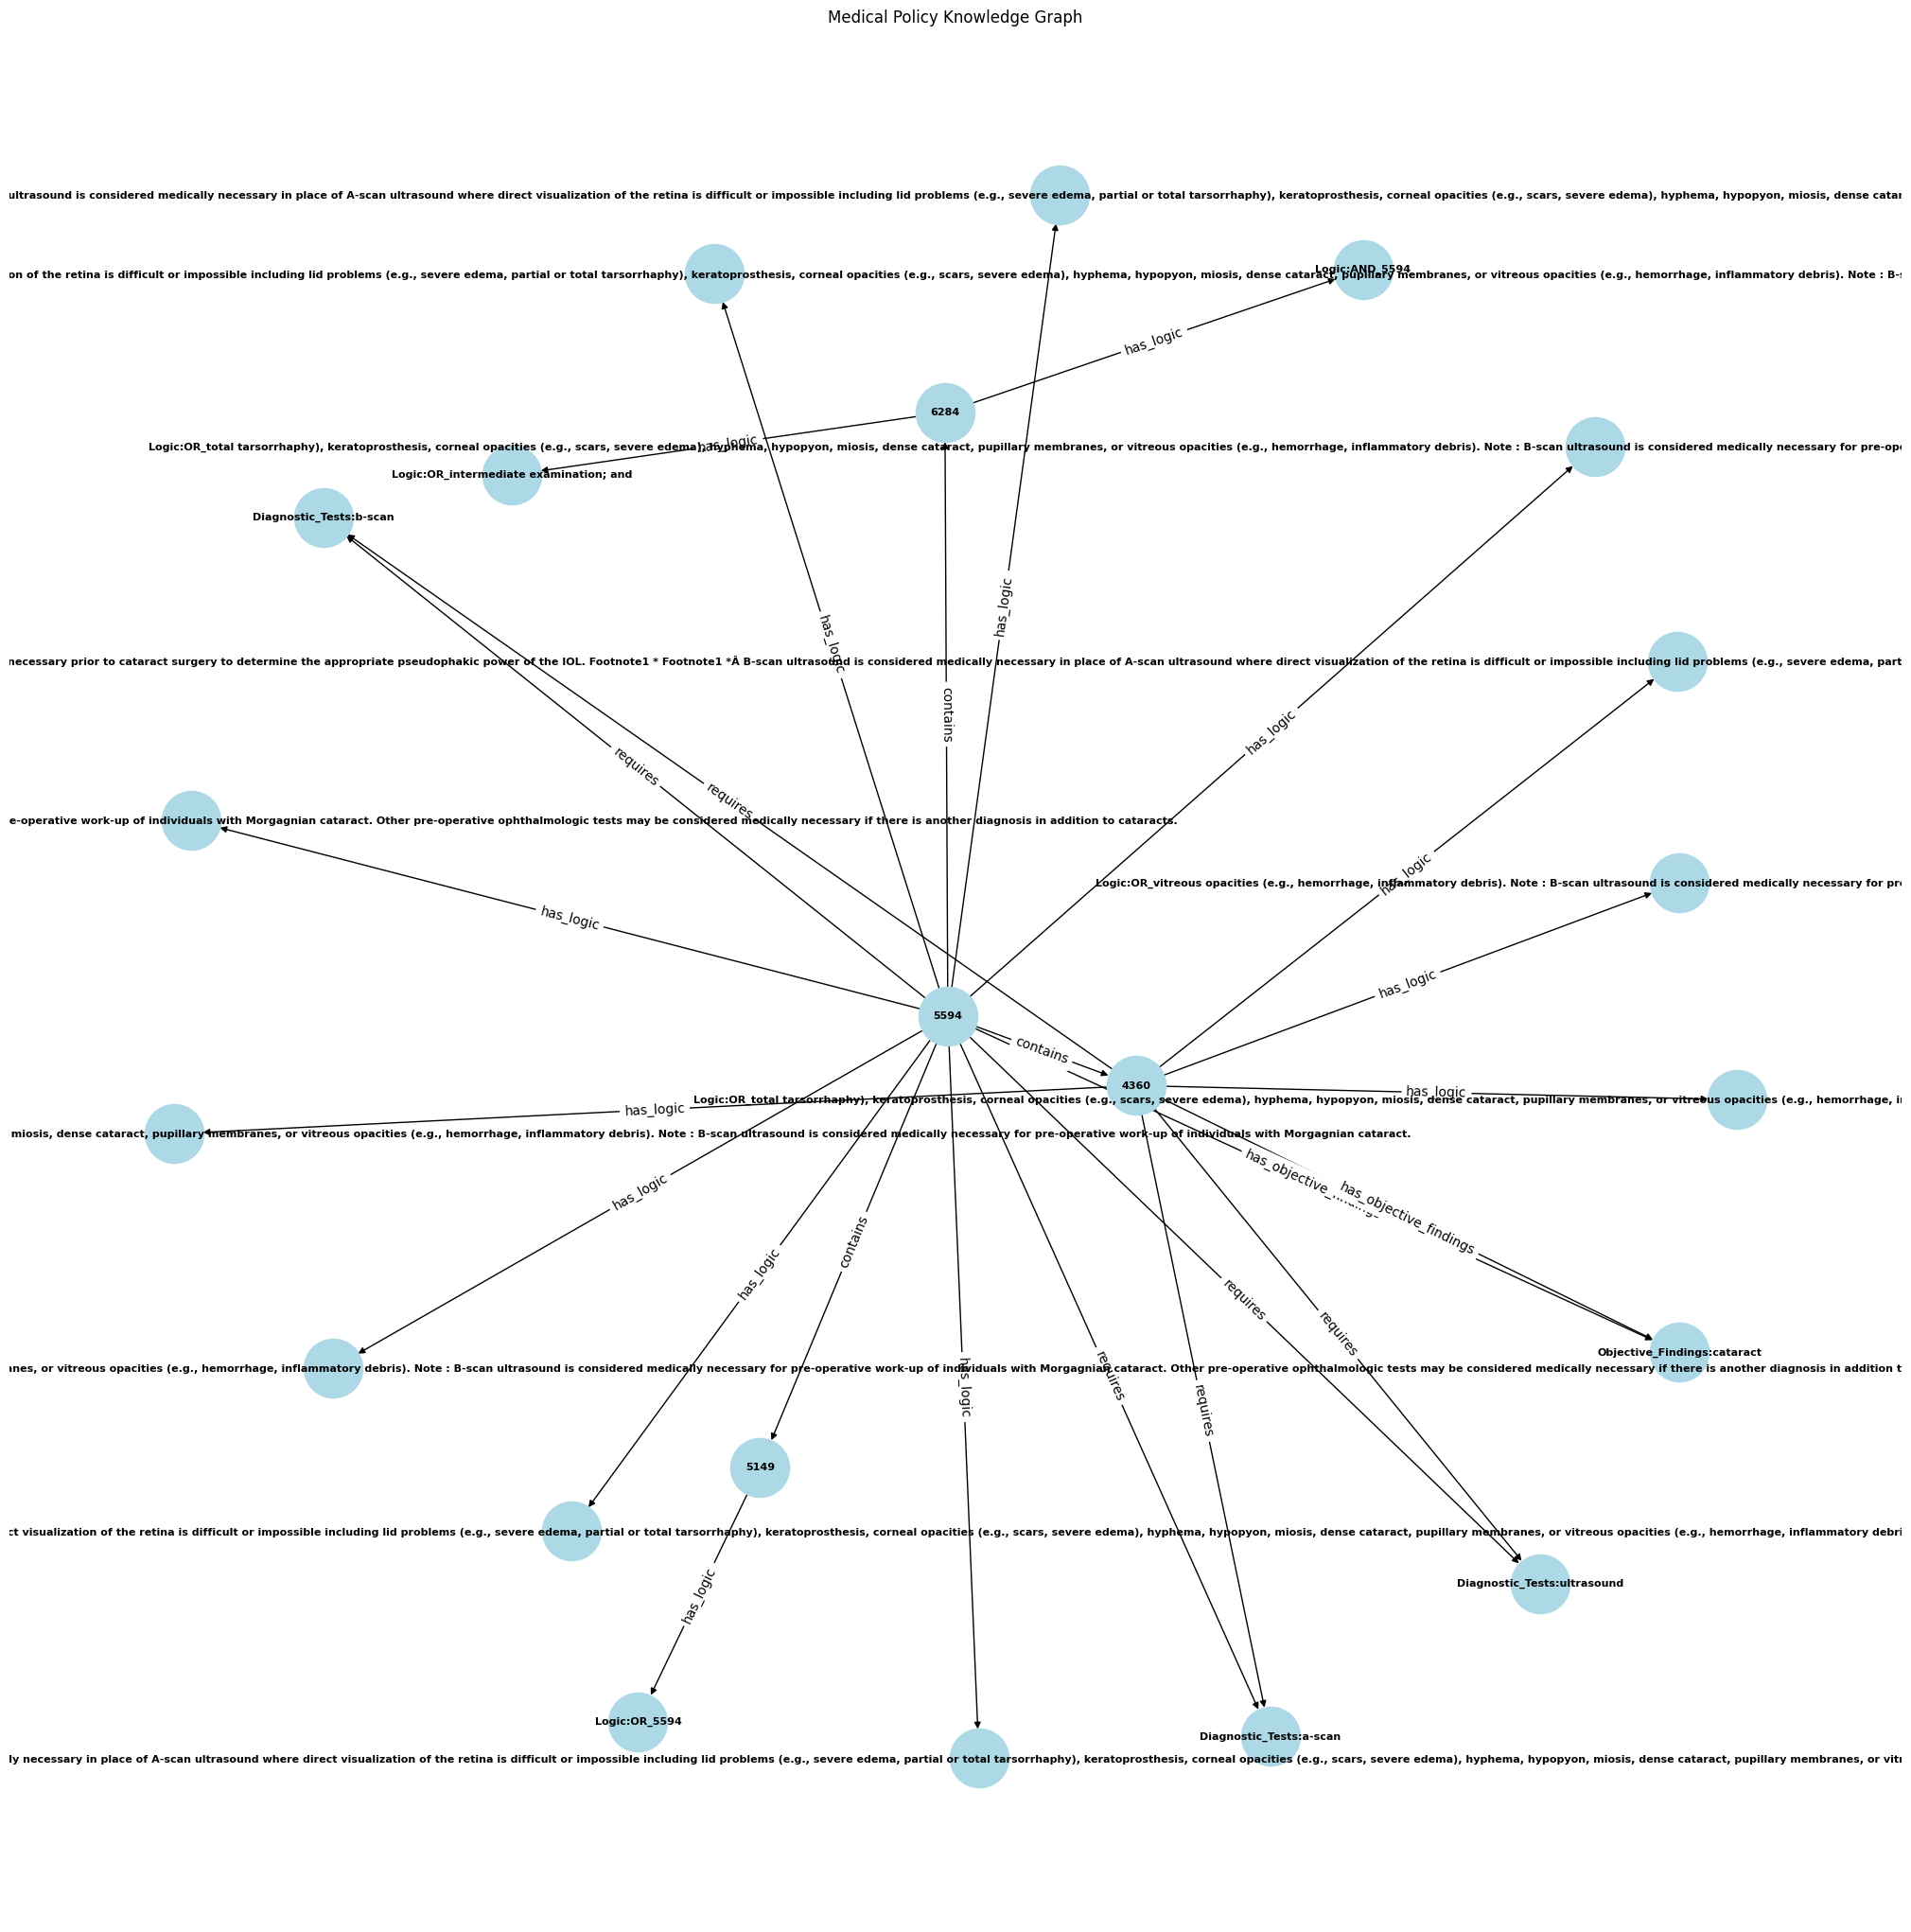

In [126]:
def create_knowledge_graph(data):
    G = nx.DiGraph()
    
    def add_node_and_edges(item, parent=None):
        node_id = str(item['id'])
        G.add_node(node_id, text=item['text'])
        
        if parent:
            G.add_edge(parent, node_id, relationship="contains")
        
        # Add edges for standardized entities
        for category, entities in item['standardized_entities'].items():
            for entity in entities:
                entity_node = f"{category}:{entity}"
                G.add_node(entity_node, type=category)
                G.add_edge(node_id, entity_node, relationship="has_" + category.lower())
        
        # Add edges for diagnostic tests
        if 'Diagnostic_Tests' in item['standardized_entities']:
            for test in item['standardized_entities']['Diagnostic_Tests']:
                G.add_edge(node_id, f"Diagnostic_Tests:{test}", relationship="requires")
        
        # Add edges for medical conditions
        if 'Medical_Conditions' in item['standardized_entities']:
            for condition in item['standardized_entities']['Medical_Conditions']:
                G.add_edge(node_id, f"Medical_Conditions:{condition}", relationship="applies_to")
        
        # Add edges for logical structure
        for logic in item['logical_structure']:
            logic_node = f"Logic:{logic[0]}_{logic[1]}"
            G.add_node(logic_node, type="Logic")
            G.add_edge(node_id, logic_node, relationship="has_logic")
        
        # Recursively add sub-items
        for sub_item in item.get('sub_items', []):
            add_node_and_edges(sub_item, node_id)
    
    # Start with the root item
    add_node_and_edges(data)
    
    return G

with open(standardized_data_file, 'r') as f:
    data = json.load(f)

# Create the knowledge graph
G = create_knowledge_graph(data['5594'])

# Visualize the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(20, 20))
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=2000, font_size=8, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'relationship')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Medical Policy Knowledge Graph")
plt.axis('off')
plt.tight_layout()
plt.show()

# You can also save the graph for later use
nx.write_gexf(G, "medical_policy_graph.gexf")

### Version 2:
1. Ontology dictionary needs to be more comprehensive and robust 
2. Ontology dictionary should be dynamically generated instead of hard coded

Approaches:
1. Use Aetna's various policies to generate my own ontology dictionary
2. Use UMLS (United Medical Language System) API : UMLS has a comprehensive collection of many controlled vocabularies that I can use to create the dictionary
3. 


In [12]:
class MedicalNecessityStandardizer:
    def __init__(self, input_file):
        self.raw_data = self.load_json(input_file)
        self.nlp = spacy.load("en_core_web_sm")
        self.matcher = PhraseMatcher(self.nlp.vocab, attr='LOWER')
        self.ontology = self.create_ontology()
        self.create_matcher()
        self.standardized_data = {
            "criteria": {},
            "procedures": {},
            "treatments": {}
        }

    @staticmethod
    def load_json(file_path):
        with open(file_path, 'r') as file:
            return json.load(file)

    @staticmethod
    def create_ontology():
        return {
            "Visual_Acuity": ["Snellen", "LogMAR", "20/20", "20/40", "20/50", "20/60", "20/70", "20/200"],
            "Functional_Impairment": ["ADL", "driving", "reading", "television", "occupational", "avocational", "lifestyle", "independence"],
            "Objective_Findings": ["cataract", "glaucoma", "retinopathy", "opacity", "clouding"],
            "Subjective_Symptoms": ["glare", "blurred vision", "diplopia", "polyopia"],
            "Diagnostic_Tests": ["A-scan", "B-scan", "ultrasound", "optical coherence biometry", "glare testing", "contrast sensitivity testing"],
            "Medical_Conditions": ["diabetes", "hypertension", "Marfan syndrome"],
            "Surgical_Procedures": ["phacoemulsification", "ECCE", "vitrectomy", "trabeculoplasty"],
            "Treatment_Types": ["IOL", "laser", "surgery", "medication"],
            "Criteria_Types": ["subjective", "objective", "educational"],
            "Logical_Operators": ["and", "or", "not"]
        }

    def create_matcher(self):
        for category, terms in self.ontology.items():
            patterns = [self.nlp.make_doc(text.lower()) for text in terms]
            self.matcher.add(category, None, *patterns)

    def extract_entities(self, text):
        doc = self.nlp(text.lower())
        matches = self.matcher(doc)
        
        entities = {category: set() for category in self.ontology.keys()}
        for match_id, start, end in matches:
            category = self.nlp.vocab.strings[match_id]
            span = doc[start:end]
            entities[category].add(span.text)
        
        return {category: list(terms) for category, terms in entities.items() if terms}

    def process_item(self, item):
        processed_item = {
            "text": item["text"],
            "entities": self.extract_entities(item["text"]),
            "sub_items": []
        }
        
        if "sub_items" in item:
            for sub_item in item["sub_items"]:
                processed_item["sub_items"].append(self.process_item(sub_item))
        
        return processed_item

    def identify_treatment(self, item):
        entities = item["entities"]
        if "Treatment_Types" in entities:
            return entities["Treatment_Types"][0]
        return "general"

    def categorize_criterion(self, item):
        entities = item["entities"]
        if "Criteria_Types" in entities:
            return entities["Criteria_Types"][0]
        return "uncategorized"

    def process_criteria(self, items):
        criteria = {}
        for item in items:
            treatment = self.identify_treatment(item)
            if treatment not in criteria:
                criteria[treatment] = {}
            
            category = self.categorize_criterion(item)
            if category not in criteria[treatment]:
                criteria[treatment][category] = []
            
            criteria[treatment][category].append(item)
        
        return criteria

    def standardize(self):
        processed_data = [self.process_item(item) for item in self.raw_data]
        self.standardized_data["criteria"] = self.process_criteria(processed_data)

    def save_json(self, output_file):
        with open(output_file, 'w') as file:
            json.dump(self.standardized_data, file, indent=2)

# Usage
treatment_id = "0508"
raw_data_file = f"medical_necessity_criteria_{treatment_id}.json"
raw_data_file_path = os.path.join(os.getcwd(), 'aetna_raw_data', raw_data_file)
standardizer = MedicalNecessityStandardizer(raw_data_file_path)
standardizer.standardize()
standardizer.save_json('output.json')